In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
From (redirected): https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk&confirm=t&uuid=c023f7fc-9498-4991-8949-ac604684c598
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:29<00:00, 28.6MB/s]


In [3]:
IMAGE_WIDTH = 60
IMAGE_HEIGHT = 60
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [4]:
filenames = os.listdir("./train")
categories = []

for filename in filenames:
  category = filename.split('.')[0]
  if category == "dog":
    categories.append(1)
  elif category == "cat":
    categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'class': categories
})

df.head()

,filename,class
0,dog.2160.jpg,1
1,dog.2740.jpg,1
2,dog.7951.jpg,1
3,cat.3109.jpg,0
4,dog.4617.jpg,1


<Axes: xlabel='class'>

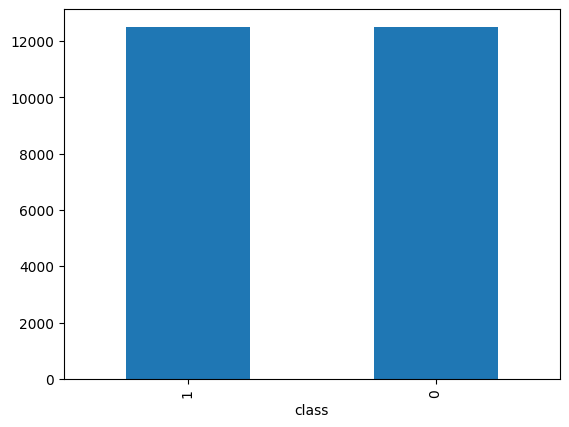

In [5]:
df['class'].value_counts().plot.bar()

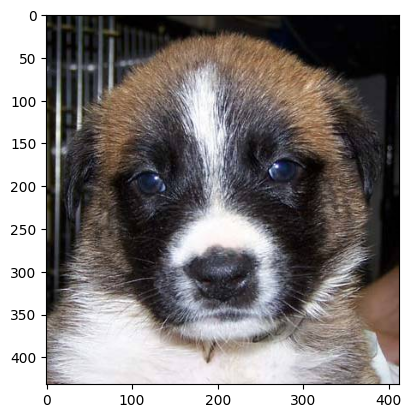

In [6]:
sample = random.choice(filenames)
image = load_img("./train/" + sample)
plt.imshow(image)

In [7]:
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

In [8]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 64)          0

In [9]:
df['class'] = df['class'].replace({0: 'cat', 1: 'dog'})
df.head()

,filename,class
0,dog.2160.jpg,dog
1,dog.2740.jpg,dog
2,dog.7951.jpg,dog
3,cat.3109.jpg,cat
4,dog.4617.jpg,dog


In [10]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=7)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [11]:
train_df

,filename,class
0,dog.10387.jpg,dog
1,dog.7100.jpg,dog
2,cat.9844.jpg,cat
3,cat.9069.jpg,cat
4,dog.6548.jpg,dog
...,...,...
19995,cat.11474.jpg,cat
19996,cat.3880.jpg,cat
19997,dog.7132.jpg,dog
19998,cat.3977.jpg,cat


In [12]:
validate_df.head()

,filename,class
0,cat.12381.jpg,cat
1,cat.11981.jpg,cat
2,dog.12283.jpg,dog
3,cat.4985.jpg,cat
4,dog.1552.jpg,dog


In [13]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "train/",
    x_col="filename",
    y_col="class",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size

)

Found 20000 validated image filenames belonging to 2 classes.


In [14]:
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = train_datagen.flow_from_dataframe(
    validate_df,
    "train/",
    x_col="filename",
    y_col="class",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size

)

Found 5000 validated image filenames belonging to 2 classes.


In [15]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    validate_df,
    "train/",
    x_col="filename",
    y_col="class",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size

)

Found 5000 validated image filenames belonging to 2 classes.


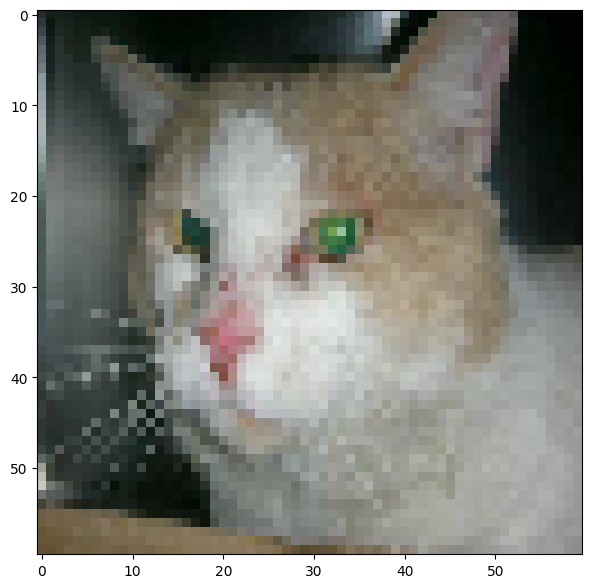

In [16]:
plt.figure(figsize=(6, 6))

for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    plt.imshow(image)
    break

plt.tight_layout()
plt.show()

In [17]:
epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=5000//batch_size,
    steps_per_epoch=20000//batch_size
)

Epoch 1/10
625/625 [==============================] - 35s 48ms/step - loss: 0.6224 - accuracy: 0.6424 - val_loss: 0.5751 - val_accuracy: 0.6901
Epoch 2/10
625/625 [==============================] - 30s 49ms/step - loss: 0.5058 - accuracy: 0.7522 - val_loss: 0.4785 - val_accuracy: 0.7646
Epoch 3/10
625/625 [==============================] - 30s 49ms/step - loss: 0.4462 - accuracy: 0.7898 - val_loss: 0.4410 - val_accuracy: 0.7969
Epoch 4/10
625/625 [==============================] - 31s 49ms/step - loss: 0.3974 - accuracy: 0.8192 - val_loss: 0.4352 - val_accuracy: 0.7891
Epoch 5/10
625/625 [==============================] - 30s 48ms/step - loss: 0.3536 - accuracy: 0.8431 - val_loss: 0.4031 - val_accuracy: 0.8163
Epoch 6/10
625/625 [==============================] - 30s 49ms/step - loss: 0.3039 - accuracy: 0.8677 - val_loss: 0.5184 - val_accuracy: 0.7897
Epoch 7/10
625/625 [==============================] - 30s 48ms/step - loss: 0.2539 - accuracy: 0.8931 - val_loss: 0.4495 - val_accuracy:

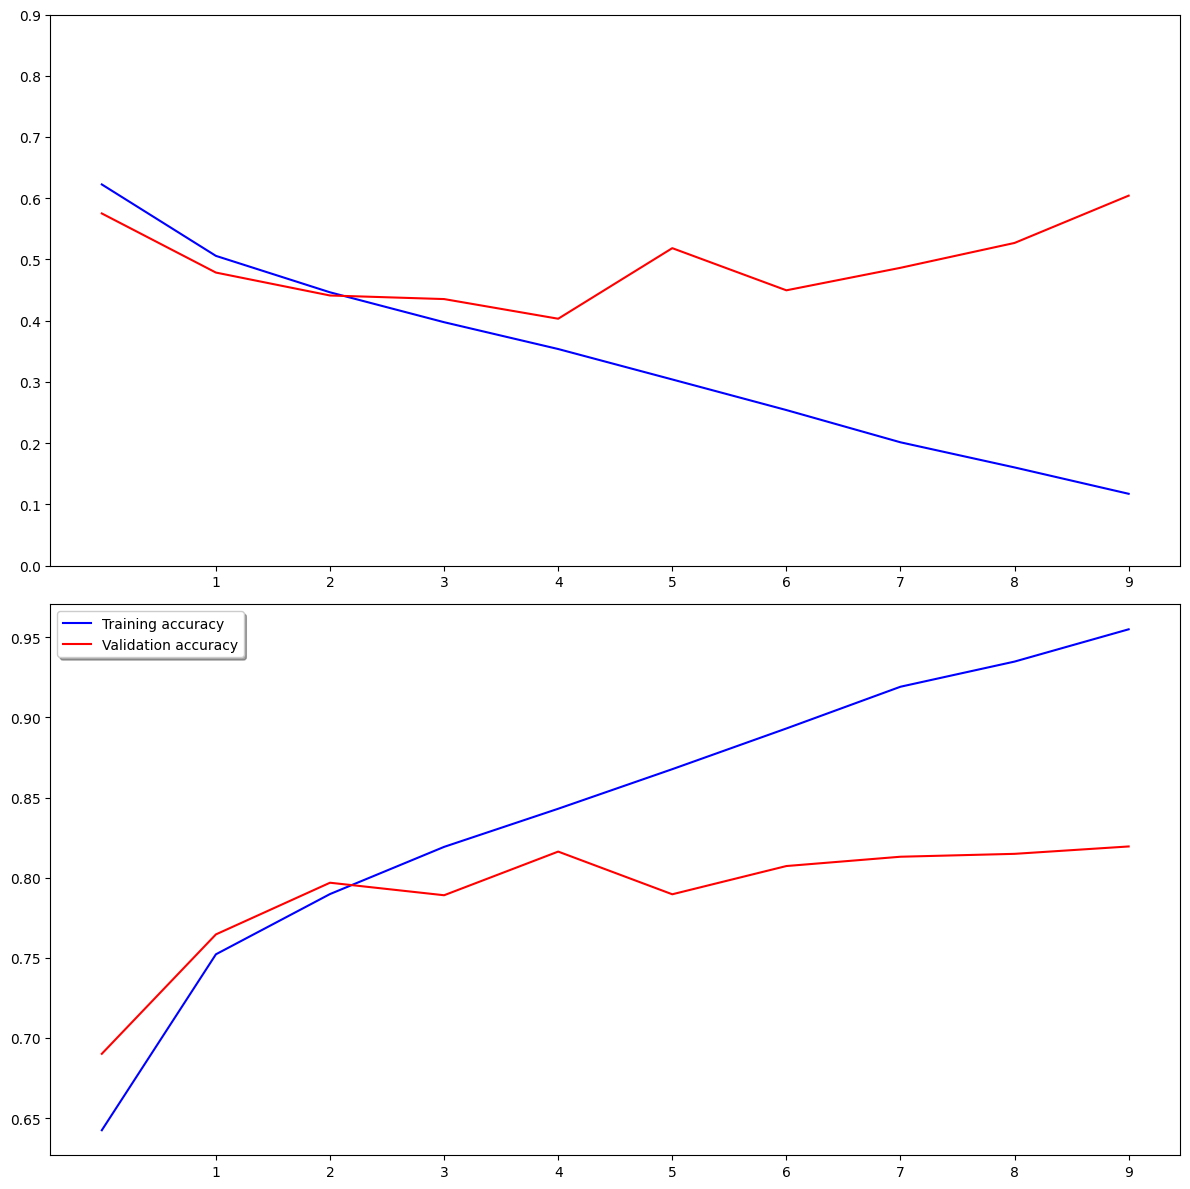

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [20]:
predict = model.predict_generator(validation_generator, steps=np.ceil(5005/batch_size))

<ipython-input-20-74d939ec8b0c>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(validation_generator, steps=np.ceil(5005/batch_size))


In [21]:
validate_df['predicted'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predicted'] = validate_df['predicted'].replace(label_map)
validate_df

,filename,class,predicted
0,cat.12381.jpg,cat,dog
1,cat.11981.jpg,cat,cat
2,dog.12283.jpg,dog,dog
3,cat.4985.jpg,cat,cat
4,dog.1552.jpg,dog,dog
...,...,...,...
4995,cat.7460.jpg,cat,dog
4996,dog.6095.jpg,dog,dog
4997,dog.12139.jpg,dog,cat
4998,cat.12007.jpg,cat,dog


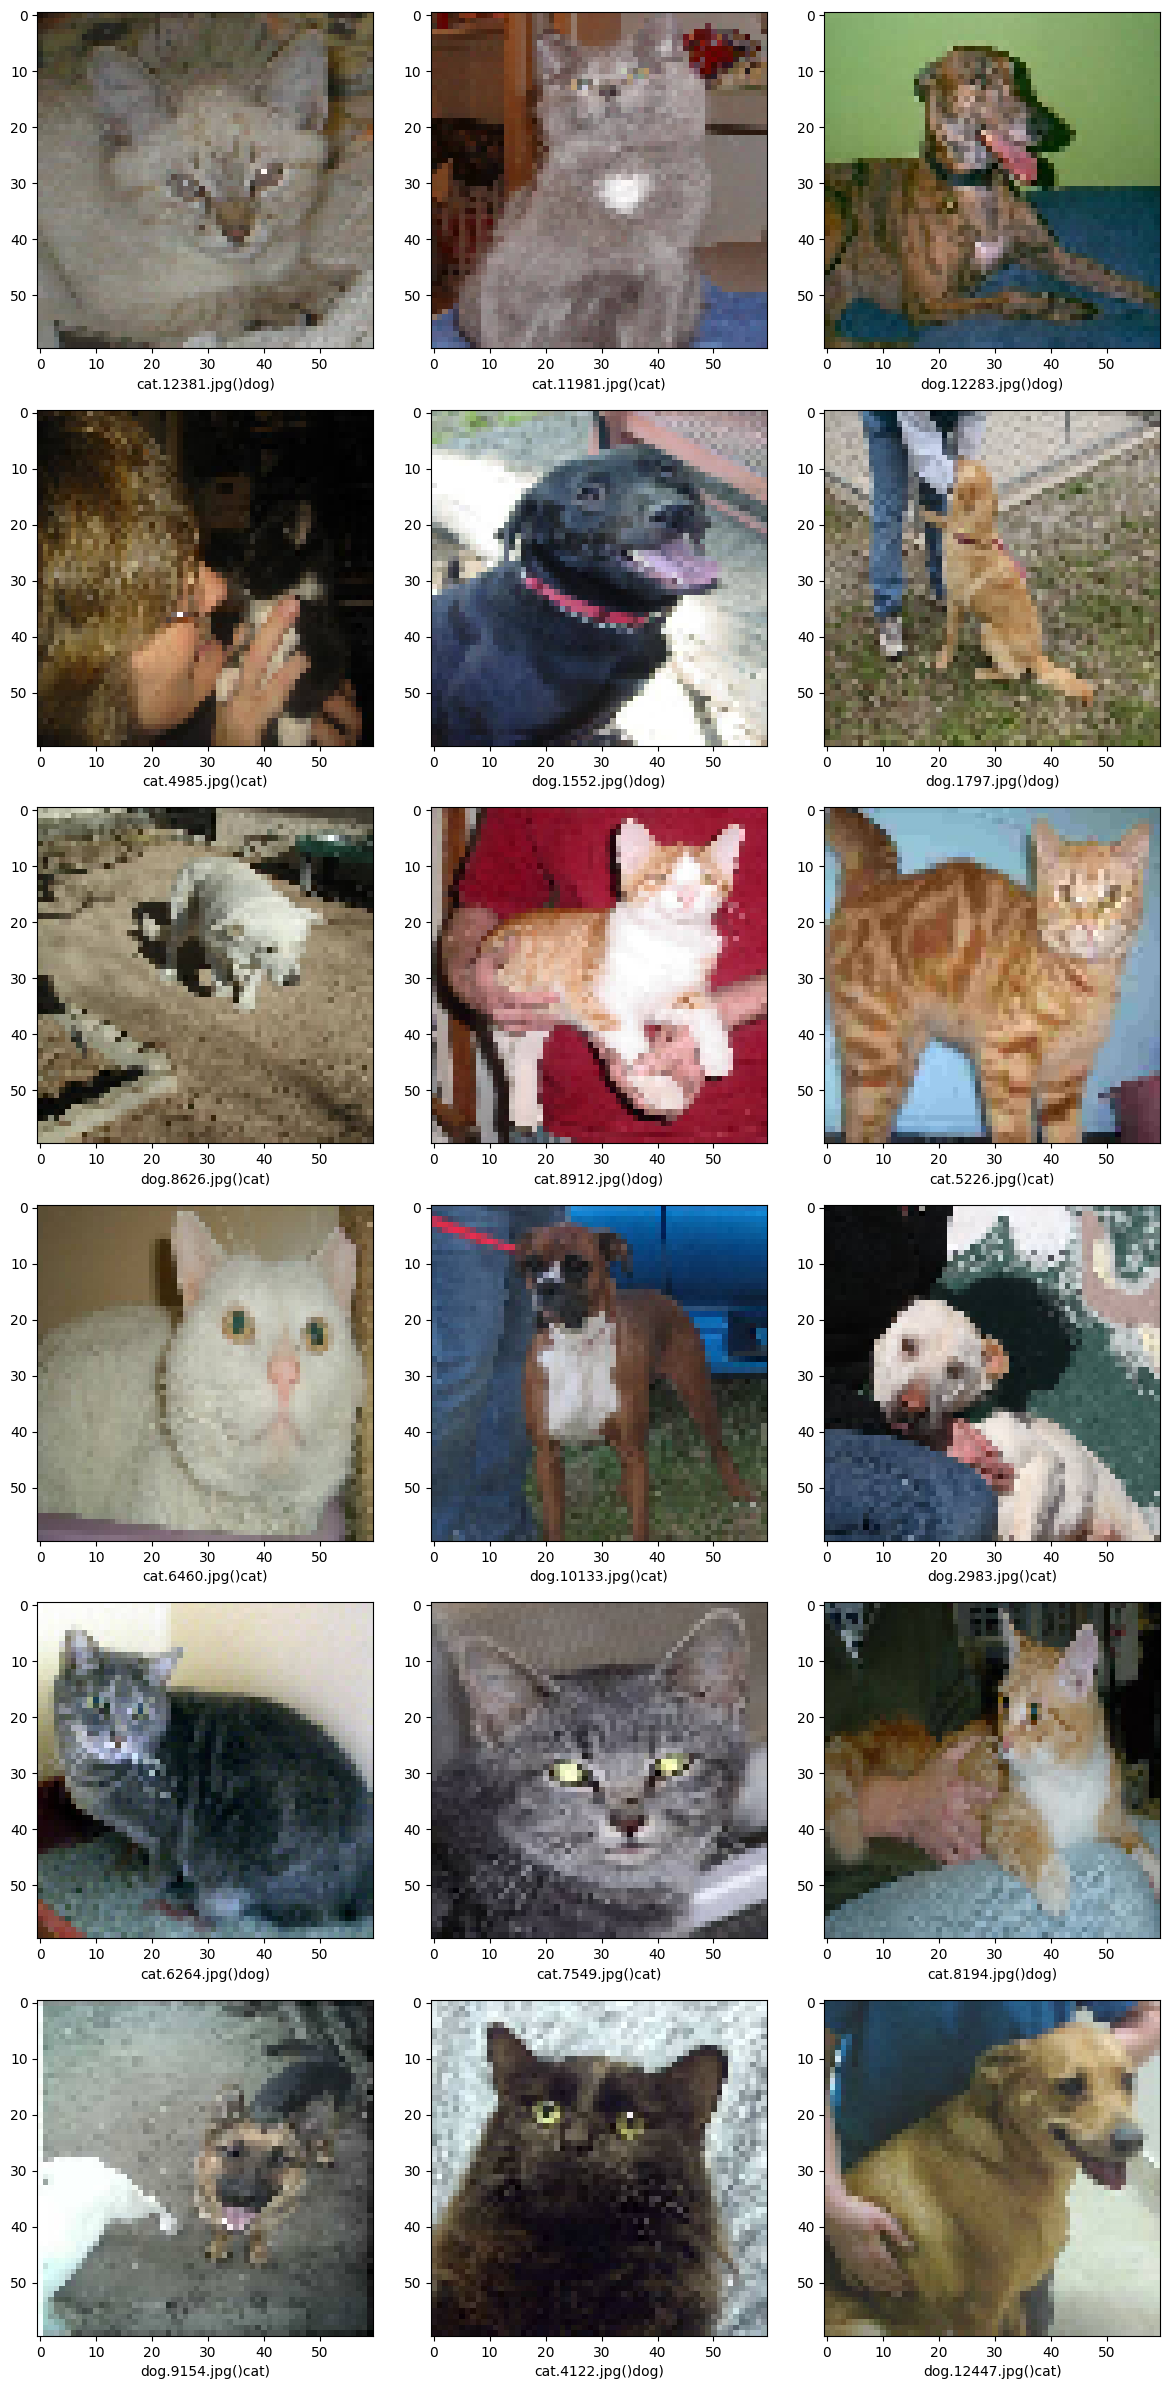

In [23]:
sample_test = validate_df.head(18)
sample_test.head()

plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
  filename = row["filename"]
  category = row["predicted"]
  img = load_img("./train/"+filename, target_size=IMAGE_SIZE)
  plt.subplot(6, 3, index+1)
  plt.imshow(img)
  plt.xlabel(filename+"()"+"{}".format(category)+")")

plt.tight_layout()
plt.show()

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [25]:
checkpoint = ModelCheckpoint("MNIST_Checkpoint.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 5, #Number of epochs we wait before stopping
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

In [26]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks = [earlystop, checkpoint, reduce_lr]

In [27]:
epochs = 10

history = model.fit(
    train_generator,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = 5000//batch_size,
    steps_per_epoch = 20000//batch_size,
)

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9676
Epoch 1: val_loss improved from inf to 0.63797, saving model to MNIST_Checkpoint.h5
625/625 [==============================] - 30s 48ms/step - loss: 0.0863 - accuracy: 0.9676 - val_loss: 0.6380 - val_accuracy: 0.8209 - lr: 5.0000e-04
Epoch 2/10
  3/625 [..............................] - ETA: 24s - loss: 0.0473 - accuracy: 0.9896

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9741
Epoch 2: val_loss did not improve from 0.63797
625/625 [==============================] - 30s 47ms/step - loss: 0.0695 - accuracy: 0.9741 - val_loss: 0.6993 - val_accuracy: 0.8091 - lr: 5.0000e-04
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9800
Epoch 3: val_loss did not improve from 0.63797
625/625 [==============================] - 30s 47ms/step - loss: 0.0552 - accuracy: 0.9800 - val_loss: 0.7782 - val_accuracy: 0.8121 - lr: 5.0000e-04
Epoch 4/10
624/625 [============================>.] - ETA: 0s - loss: 0.0576 - accuracy: 0.9795
Epoch 4: val_loss did not improve from 0.63797

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
625/625 [==============================] - 30s 47ms/step - loss: 0.0575 - accuracy: 0.9795 - val_loss: 0.7629 - val_accuracy: 0.8183 - lr: 5.0000e-04
Epoch 5/10
625/625 [==============================] - 